[Load Data](#load)

[Data Preparation](#prepare)
1. [Balance and Split](#bs)
2. [Scale](#scale)

[Model](#model)
1. [Random Forest](#rf)
2. [Gaussian NB](#gnb)
3. [Logistic Regression](#logit)
4. [KNN](#knn)
5. [Neural Network](#nn)

[Evaluation](#evaluation)
1. [Precision & Recall](#precision_recall)
2. [AUC ROC](#auc_roc)

In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm_notebook as tqdm

<a id='load'></a>
# Load data

In [4]:
data = pd.read_csv('./4_22_2020_data.csv')

<a id='prepare'></a>
# Prepare data

In [5]:
exclude = ['horse_num','oriental_sum','apple_sum','pro_sum',
           'total_1','total_2','total_3','total_sum','file_name',
           'sheet_name','W.H. FixOdd 60','S.B.Fix Odd 60']

In [6]:
data_ex = data[[i for i in list(data) if i not in exclude]].dropna()
X = data_ex[[i for i in data_ex if i != 'result']]
y = (data_ex['result'] > 0).astype('int')

In [7]:
# plt.figure(figsize=(10,10))
# sns.heatmap(data_ex.corr(), square=True, cmap='PiYG')
# plt.show()

<a id='bs'></a>
## Balance and Split

In [8]:
from imblearn import over_sampling, under_sampling
from imblearn.pipeline import Pipeline

Using TensorFlow backend.


In [9]:
# create sampling strategy
# both oversampling and undersampling
over = over_sampling.SMOTE(0.8)
under = under_sampling.RandomUnderSampler(0.8)

In [10]:
# create pipeline
pipeline = Pipeline([('o', over),('u', under)])

In [11]:
X_sam, y_sam = pipeline.fit_resample(X, y)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_sam, y_sam, test_size=0.15)

<a id='scale'></a>
## Scale

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
X_train_n = scaler.transform(X_train)
X_test_n = scaler.transform(X_test)

<a id='model'></a>
# Model

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
def precision_recall(true, predict, print_=True):
    cm = confusion_matrix(true, predict)
    if print_:
        print('Confusion Matrix:')
        print(cm)
        print()
    
    tn, fp, fn, tp = confusion_matrix(true, predict).ravel()
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    
    if print_:
        print('Precision:', precision)
        print('Recall:', recall)
    else:
        return precision, recall

<a id='rf'></a>
## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [21]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [20]:
# rf = RandomForestClassifier()

# rf_random = RandomizedSearchCV(estimator=rf, 
#                                param_distributions=random_grid, 
#                                n_iter = 100, 
#                                cv = 5, 
#                                verbose=2,
#                                random_state=42, 
#                                n_jobs = -1)

In [21]:
# rf_random.fit(X_train, y_train)

In [34]:
# rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [35]:
# # old
# rf_best_old = RandomForestClassifier(n_estimators=800, 
#                                  min_samples_split=2,
#                                  min_samples_leaf=2,
#                                  max_features='sqrt',
#                                  max_depth=50,
#                                  bootstrap=False)

In [22]:
rf_best = RandomForestClassifier(n_estimators=1400, 
                                 min_samples_split=5,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=80,
                                 bootstrap=False)

In [23]:
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
precision_recall(y_test, rf_best.predict(X_test), print_=True)

Confusion Matrix:
[[544  64]
 [ 97 400]]

Precision: 0.8620689655172413
Recall: 0.8048289738430584


In [25]:
import pickle

In [60]:
filename = 'model_rf_4_24.sav'
pickle.dump(rf_best, open(filename, 'wb'))

<a id='svm'></a>
## SVM

In [26]:
from sklearn.svm import SVC

In [27]:
svm = SVC(gamma='auto',)
svm.fit(X_train_n, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

<a id='gnb'></a>
## Gaussian NB

In [28]:
from sklearn.naive_bayes import GaussianNB

In [29]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

<a id='logit'></a>
## Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegressionCV

In [31]:
logit = LogisticRegressionCV(cv=10, verbose=2)
logit.fit(X_train_n, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=2)

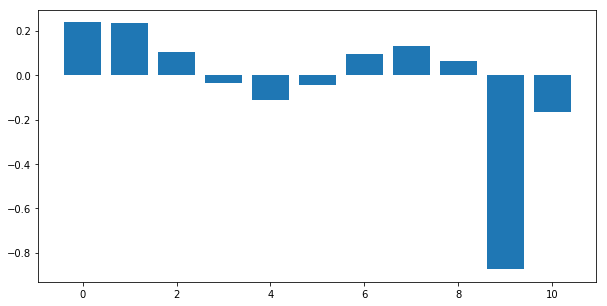

In [32]:
plt.figure(figsize=(10,5))
plt.bar(range(len(logit.coef_.reshape(-1))), logit.coef_.reshape(-1))
plt.show()

<a id='knn'></a>
## KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [34]:
def knn_cv(n, X, y):
    knn = KNeighborsClassifier(n_neighbors=n)
    score = cross_val_score(knn, X, y, cv=10)
    return score.mean()

In [35]:
all_knn_scores = [knn_cv(i, X_train_n, y_train) for i in tqdm(range(3, 99, 2))]

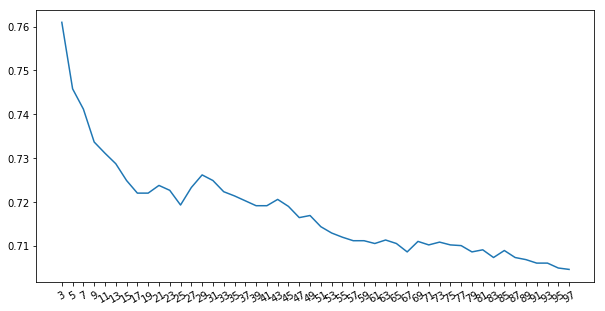

In [36]:
plt.figure(figsize=(10,5))
plt.plot(all_knn_scores)
plt.xticks(range(len(all_knn_scores)), range(3,99,2), rotation=30)
plt.show()

In [37]:
knn_best = KNeighborsClassifier(n_neighbors=3)
knn_best.fit(X_train_n, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

<a id='nn'></a>
## Neural Network

In [38]:
X_val_n, X_test_dnn, y_val, y_test_dnn = train_test_split(X_test_n, y_test, test_size=0.2)

In [39]:
from keras import models
from keras import layers

In [40]:
dnn = models.Sequential()
dnn.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu'))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn.add(layers.Dropout(0.2))
dnn.add(layers.Dense(1, activation='sigmoid'))

W0502 21:14:16.741622 4508767680 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0502 21:14:16.760931 4508767680 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0502 21:14:16.787948 4508767680 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0502 21:14:16.814853 4508767680 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0502 21:14:16.826373 4508767680 deprecati

In [41]:
dnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

W0502 21:14:18.809587 4508767680 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0502 21:14:18.830336 4508767680 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0502 21:14:18.834836 4508767680 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [42]:
history = dnn.fit(X_train_n, y_train, 
                    epochs=100, 
                    batch_size=512, 
                    verbose=0,
                    validation_data=[X_val_n, y_val])

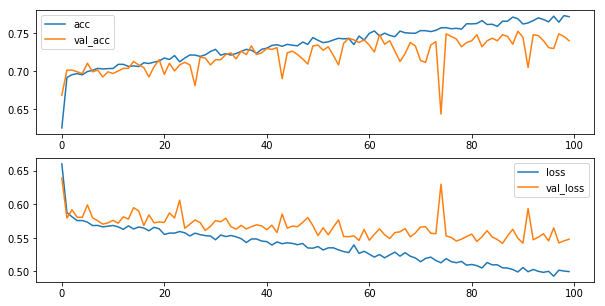

In [43]:
plt.figure(figsize=(10,5))

plt.subplot(2,1,1)
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.show()

In [44]:
dnn_best = models.Sequential()
dnn_best.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu'))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(128, activation='relu', input_shape=(11,)))
dnn_best.add(layers.Dropout(0.2))
dnn_best.add(layers.Dense(1, activation='sigmoid'))

In [45]:
dnn_best.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [46]:
history_best = dnn_best.fit(X_train_n, y_train, 
                            epochs=40, 
                            batch_size=512, 
                            verbose=0,
                            validation_data=[X_val_n, y_val])

<a id='evaluation'></a>
# Evaluation

<a id='precision_recall'></a>
## Precision & Recall

In [47]:
# random forest
rf_score = rf_best.score(X_test, y_test)
rf_predict = rf_best.predict(X_test)

In [48]:
# svm
svm_score = svm.score(X_test_n, y_test)
svm_predict = svm.predict(X_test_n)

In [49]:
# gnb
gnb_score = gnb.score(X_test, y_test)
gnb_predict = gnb.predict(X_test)

In [50]:
# logistic regression
logit_score = logit.score(X_test_n, y_test)
logit_predict = logit.predict(X_test_n)

In [51]:
# knn
knn_score = knn_best.score(X_test_n, y_test)
knn_predict = knn_best.predict(X_test_n)

In [52]:
# nn
dnn_loss, dnn_score = dnn_best.evaluate(X_test_dnn, y_test_dnn)
dnn_predict = pd.Series(dnn_best.predict(X_test_dnn).reshape(-1) >= 0.5).astype('int')

221/221 [==============================] - 0s 50us/step


In [53]:
from sklearn.metrics import roc_curve, auc

In [54]:
dnn_fpr, dnn_tpr, dnn_threshold = roc_curve(y_test_dnn, dnn_best.predict(X_test_dnn).reshape(-1))
dnn_auc = auc(dnn_fpr, dnn_tpr)

In [55]:
pr_dict = {
    'rf':precision_recall(y_test, rf_predict, print_=False),
    'svm':precision_recall(y_test, svm_predict, print_=False),
    'gnb':precision_recall(y_test, gnb_predict, print_=False),
    'logit':precision_recall(y_test, logit_predict, print_=False),
    'knn':precision_recall(y_test, knn_predict, print_=False),
    'dnn':precision_recall(y_test_dnn, dnn_predict, print_=False)
}

In [56]:
pr_df = pd.DataFrame.from_dict(pr_dict, orient='index', columns=['precision','recall'])
pr_df['F1'] = 2*((pr_df['precision']*pr_df['recall']) / (pr_df['precision']+pr_df['recall']))
pr_df['accuracy'] = [rf_score, svm_score, gnb_score, logit_score, knn_score, dnn_score]

In [57]:
pr_df

,precision,recall,F1,accuracy
rf,0.862069,0.804829,0.832466,0.854299
svm,0.694444,0.653924,0.673575,0.714932
gnb,0.670306,0.617706,0.642932,0.691403
logit,0.673036,0.637827,0.654959,0.697738
knn,0.705387,0.843058,0.768103,0.771041
dnn,0.610294,0.855670,0.712446,0.696833


<a id='auc_roc'></a>
## AUC ROC

In [58]:
from sklearn.metrics import plot_roc_curve

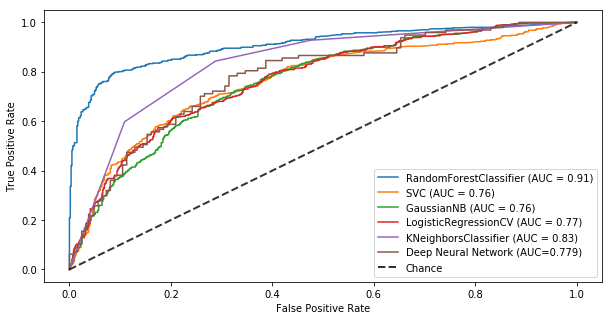

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
plot_roc_curve(rf_best, X_test, y_test, ax=ax)
plot_roc_curve(svm, X_test_n, y_test, ax=ax)
plot_roc_curve(gnb, X_test, y_test, ax=ax)
plot_roc_curve(logit, X_test_n, y_test, ax=ax)
plot_roc_curve(knn_best, X_test_n, y_test, ax=ax)
plt.plot(dnn_fpr, dnn_tpr, label='Deep Neural Network (AUC={})'.format(round(dnn_auc, 3)))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
        label='Chance', alpha=.8)
plt.legend()
plt.show()